# 32 Finding Similar Companies with Nearest Neighbors

* Top 500 US companies dataset

This notebook shows a basic process:

* taking a public data set (from http://www.opendata500.com/us/list/)
* inspection
* cleaning
* converting features to categorical variables
* test a nearest neighbor search to find similar companies
* adjusting the data used for queries

This data set is relatively small and does not include financials, just business domain, company size and customer types.

## Basic inspections

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline

```
!head -2 us_companies.csv
```

> company_name_id,company_name,url,year_founded,city,state,country,zip_code,full_time_employees,company_type,company_category,revenue_source,business_model,social_impact,description,description_short,source_count,data_types,example_uses,data_impacts,financial_info,last_updated
3-round-stones-inc,"3 Round Stones, Inc.",http://3RoundStones.com,2010,Washington,DC,us,20004,1-10,Private,Data/Technology,"Data analysis for clients, Database licensing, Subscriptions","Business to Business, Business to Consumer",,"3 Round Stones produces a platform for publishing data on the Web. 3 Round Stones provides commercial support for the Callimachus Data Platform, used by the Fortune 2000 and US Government Agencies publishing and consuming data.  Headquartered in Arlington, Virginia, we're seasoned entrepreneurs who are passionate about solving real world problems through open data and open Web standards.","Our Open Source platform is used by the Fortune2000 and US Government Agencies to collect, publish and reuse data, both public and proprietary.",NA,,,[],"3 Round Stones is a profitable, self-funded, woman-owned start-up.  Our team has several successful serial entrepreneurs.  As entrepreneurs, we've benefited from the valuable guidance by seasoned advisers and mentors in the mid-Atlantic region who have guided our team through multiple start-ups, outside funding and an acquisition by a Fortune 100 company in 2005.",2014-11-12 14:44:25.969871

In [2]:
df = pd.read_csv("data/us_companies.csv", sep=",")

In [3]:
df.head()

,company_name_id,company_name,url,year_founded,city,state,country,zip_code,full_time_employees,company_type,...,business_model,social_impact,description,description_short,source_count,data_types,example_uses,data_impacts,financial_info,last_updated
0,3-round-stones-inc,"3 Round Stones, Inc.",http://3RoundStones.com,2010.0,Washington,DC,us,20004.0,1-10,Private,...,"Business to Business, Business to Consumer",NaN,3 Round Stones produces a platform for publish...,Our Open Source platform is used by the Fortun...,NaN,NaN,NaN,[],"3 Round Stones is a profitable, self-funded, w...",2014-11-12 14:44:25.969871
1,48-factoring-inc,48 Factoring Inc.,https://www.48factoring.com,2014.0,Philadelphia,PA,us,19087.0,51-200,Private,...,Business to Business,Small Business Owners,The company mission is to provide finance to s...,48 Factoring Inc. is one of the best financial...,11-50,Business,NaN,"[u'Cost efficiency', u'Job growth', u'Revenue ...",NaN,2015-05-18 11:36:39.902880
2,5psolutions,5PSolutions,www.5psolutions.com,2007.0,Fairfax,VA,us,22003.0,1-10,Private,...,"Business to Business, Business to Consumer, Bu...",NaN,"At 5PSolutions, we wish to make all basic info...",5PSolutions are artisans of mobile platforms.,NaN,NaN,NaN,[],NaN,2014-11-12 15:09:35.485949
3,abt-associates,Abt Associates,abtassoc.com,1965.0,Cambridge,MA,us,2138.0,"1,001-5,000",Private,...,NaN,NaN,"Abt Associates is a mission-driven, internatio...","Abt Associates is a mission-driven, global lea...",101+,NaN,NaN,[],Employee-owned company. $552M/year.,2014-09-11 17:23:21.390289
4,accela,Accela,http://www.accela.com,1999.0,San Ramon,CA,us,94583.0,"501-1,000",Private,...,Business to Consumer,"Citizen engagement and participation, Good gov...",Accela powers thousands of services and millio...,Accela improves citizen engagement by making i...,101+,"Health/Healthcare, Housing, Public Safety",NaN,[],NaN,2014-09-16 16:30:49.172802


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 529 entries, 0 to 528
Data columns (total 22 columns):
company_name_id        529 non-null object
company_name           529 non-null object
url                    529 non-null object
year_founded           528 non-null float64
city                   496 non-null object
state                  529 non-null object
country                529 non-null object
zip_code               492 non-null float64
full_time_employees    500 non-null object
company_type           513 non-null object
company_category       526 non-null object
revenue_source         519 non-null object
business_model         453 non-null object
social_impact          16 non-null object
description            529 non-null object
description_short      529 non-null object
source_count           226 non-null object
data_types             142 non-null object
example_uses           8 non-null object
data_impacts           529 non-null object
financial_info         142 non-null 

In [5]:
df[df.year_founded.isnull()]

,company_name_id,company_name,url,year_founded,city,state,country,zip_code,full_time_employees,company_type,...,business_model,social_impact,description,description_short,source_count,data_types,example_uses,data_impacts,financial_info,last_updated
291,marlin-alter-and-associates,Marlin Alter and Associates,http://www.marlinalter.com/,NaN,NaN,FL,us,NaN,NaN,NaN,...,NaN,NaN,"Marlin, Alter & Associates provides background...","Marlin, Alter & Associates provides background...",101+,NaN,NaN,[],NaN,2014-10-23 14:36:57.718144


Drop the one company, that has no founding year.

In [6]:
df = df.dropna(subset=["year_founded"])

Convert years to integers.

In [7]:
df["year_founded"] = df["year_founded"].astype(int)

### Distribution of founding years

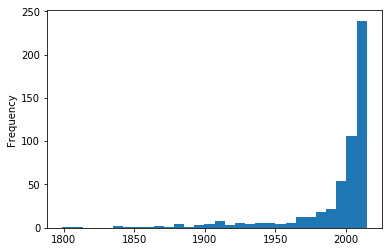

In [8]:
df.year_founded.plot(kind="hist", bins=30)

28 companies have missing values for number of employees.

In [9]:
len(df[df.full_time_employees.isnull()])

28

8 categories of company sizes.

In [10]:
df.groupby("full_time_employees").size().sort_values(ascending=False)

full_time_employees
1-10            143
11-50           115
51-200           93
10,001+          56
1,001-5,000      30
201-500          25
501-1,000        22
5,001-10,000     16
dtype: int64

In [11]:
pd.get_dummies(df["full_time_employees"]).head()

,"1,001-5,000",1-10,"10,001+",11-50,201-500,"5,001-10,000","501-1,000",51-200
0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1
2,0,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0


In [12]:
df = pd.concat([df, pd.get_dummies(df["full_time_employees"])], sort=False, axis=1)

Mostly private, some public and non-profit companies.

In [13]:
df.groupby("company_type").size().sort_values(ascending=False)

company_type
Private                           396
Public                             92
Nonprofit                          15
partnership                         4
Partnership                         2
sole proprietorship                 1
nonprofit + commercial spinoff      1
Public (Federal-USGS)               1
Permitting Assistance               1
dtype: int64

In [14]:
df.loc[df.company_type == "partnership", "company_type"] = "Partnership"
df.loc[df.company_type == "sole proprietorship", "company_type"] = "Private"
df.loc[df.company_type == "nonprofit + commercial spinoff", "company_type"] = "Nonprofit"
df.loc[df.company_type == "Public (Federal-USGS)", "company_type"] = "Public"
df.loc[df.company_type == "Permitting Assistance", "company_type"] = "Private"

In [15]:
df.groupby("company_type").size().sort_values(ascending=False)

company_type
Private        398
Public          93
Nonprofit       16
Partnership      6
dtype: int64

In [16]:
df = pd.concat([df, pd.get_dummies(df["company_type"])], sort=False, axis=1)

Lots of missing revenue source entries.

In [17]:
df.groupby("revenue_source").size().sort_values(ascending=False).index.tolist()[:10]

['Not reported by company',
 'Software licensing',
 'not reported by company',
 'Data analysis for clients, Database licensing',
 'Subscriptions',
 'Not provided by company',
 'Data analysis for clients, Database licensing, Subscriptions',
 'Subscriptions, User fees for web or mobile access',
 'Software licensing, Subscriptions',
 'Advertising']

In [18]:
df.groupby("business_model").size().sort_values(ascending=False).index.tolist()

['Business to Business',
 'Business to Consumer',
 'Business to Business, Business to Consumer',
 'Business to Business, Business to Government',
 'Business to Business, Business to Consumer, Business to Government',
 'Business to Government',
 'Business to Consumer, Business to Government',
 'Business to Business, academia',
 'Business to Government, nonprofit',
 'nonprofit',
 'Business to Business, Business to Government, academia',
 'Business to Business, nonprofit',
 'Business to Business, Business to Government, nonprofit',
 'Business to Business, Business to Consumer, Business to Government, academia',
 'Business to Business, Business to Consumer, academia + nonprofit',
 'Nonprofit',
 'Business to Business, Business to Consumer, ',
 'Business to Business, Business to Consumer, Business to Government, ',
 'Business to Business, Business to Consumer, academia',
 'Business to Consumer, nonprofit',
 'Business to Business, Business to Consumer, nonprofit',
 'Business to Consumer, Busi

### Heavy data cleaning

Try to parse out the categories.

* create a list of values, splitted on "," (comma)
* create a set out of these values
* create a mapping from values in DataFrame to normalized values

In [19]:
bm_dirty = df["business_model"].str.split(",").apply(pd.Series).values.ravel().tolist()
entries = list(set([str(val).strip() for val in bm_dirty]))
mapping = dict(zip(entries, ["NA", "B2G", "N", "B2N", "N", "NA", "B2B", "N", "B2C", "B2G"]))

In [20]:
mapping

{'': 'NA',
 'academia': 'B2G',
 'nonprofit': 'N',
 'Business to Government': 'B2N',
 'Nonprofit': 'N',
 'Business to Business': 'NA',
 'Business to Consumer': 'B2B',
 'nan': 'N',
 'Business to Nonprofit': 'B2C',
 'academia + nonprofit': 'B2G'}

In [21]:
for key in sorted(set(mapping.values())):
    df.loc[:, key] = 0
    
for i, row in df.iterrows():
    for value in str(row["business_model"]).split(","):
        df.loc[i, mapping[value.strip()]] = 1

In [22]:
df.columns

Index(['company_name_id', 'company_name', 'url', 'year_founded', 'city',
       'state', 'country', 'zip_code', 'full_time_employees', 'company_type',
       'company_category', 'revenue_source', 'business_model', 'social_impact',
       'description', 'description_short', 'source_count', 'data_types',
       'example_uses', 'data_impacts', 'financial_info', 'last_updated',
       '1,001-5,000', '1-10', '10,001+', '11-50', '201-500', '5,001-10,000',
       '501-1,000', '51-200', 'Nonprofit', 'Partnership', 'Private', 'Public',
       'B2B', 'B2C', 'B2G', 'B2N', 'N', 'NA'],
      dtype='object')

### Convert to categorical variables

In [23]:
df.loc[:, "B2B":][:10]

,B2B,B2C,B2G,B2N,N,NA
0,1,0,0,0,0,1
1,0,0,0,0,0,1
2,1,0,0,1,0,1
3,0,0,0,0,1,0
4,1,0,0,0,0,0
5,0,0,0,0,0,1
6,1,0,0,1,0,1
7,0,0,0,0,0,1
8,0,0,0,0,0,1
9,0,0,0,1,0,0


In [24]:
df.columns

Index(['company_name_id', 'company_name', 'url', 'year_founded', 'city',
       'state', 'country', 'zip_code', 'full_time_employees', 'company_type',
       'company_category', 'revenue_source', 'business_model', 'social_impact',
       'description', 'description_short', 'source_count', 'data_types',
       'example_uses', 'data_impacts', 'financial_info', 'last_updated',
       '1,001-5,000', '1-10', '10,001+', '11-50', '201-500', '5,001-10,000',
       '501-1,000', '51-200', 'Nonprofit', 'Partnership', 'Private', 'Public',
       'B2B', 'B2C', 'B2G', 'B2N', 'N', 'NA'],
      dtype='object')

In [25]:
df.groupby("company_category").size().sort_values(ascending=False)

company_category
Data/Technology              97
Finance & Investment         75
Business & Legal Services    43
Governance                   43
Healthcare                   40
Geospatial/Mapping           30
Energy                       28
Transportation               28
Research & Consulting        28
Lifestyle & Consumer         25
Housing/Real Estate          20
Education                    19
Scientific Research          17
Insurance                    11
Environment & Weather        11
Food & Agriculture            6
Housing/Real Estate,          1
Data/Technology,              1
Media                         1
Aerospace and Defense         1
dtype: int64

In [26]:
pd.get_dummies(df["company_category"]).head()

,Aerospace and Defense,Business & Legal Services,Data/Technology,"Data/Technology,",Education,Energy,Environment & Weather,Finance & Investment,Food & Agriculture,Geospatial/Mapping,Governance,Healthcare,Housing/Real Estate,"Housing/Real Estate,",Insurance,Lifestyle & Consumer,Media,Research & Consulting,Scientific Research,Transportation
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [27]:
df = pd.concat([df, pd.get_dummies(df["company_category"])], sort=False, axis=1)

In [28]:
df = df.drop(["url", "company_name", "city", "state", "country", "zip_code", "full_time_employees",
              "company_type", "company_category", "revenue_source", "business_model", "social_impact",
              "description", "description_short", "source_count", "data_types", "last_updated",
              "financial_info", "example_uses", "data_impacts"], axis=1)

In [29]:
df

,company_name_id,year_founded,"1,001-5,000",1-10,"10,001+",11-50,201-500,"5,001-10,000","501-1,000",51-200,...,Governance,Healthcare,Housing/Real Estate,"Housing/Real Estate,",Insurance,Lifestyle & Consumer,Media,Research & Consulting,Scientific Research,Transportation
0,3-round-stones-inc,2010,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,48-factoring-inc,2014,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,5psolutions,2007,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,abt-associates,1965,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,accela,1999,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
5,accenture,1989,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,accuweather,1962,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,acxiom,1969,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,adaptive,2001,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,adobe-digital-government,2009,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Exploring NearestNeighbors

In [30]:
from sklearn.neighbors import NearestNeighbors

In [31]:
X = df.loc[:, "year_founded":]

In [32]:
X.shape

(528, 39)

In [33]:
nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(X)

In [34]:
query = df[df["company_name_id"] == "accela"].loc[:, "year_founded":]

In [35]:
query

,year_founded,"1,001-5,000",1-10,"10,001+",11-50,201-500,"5,001-10,000","501-1,000",51-200,Nonprofit,...,Governance,Healthcare,Housing/Real Estate,"Housing/Real Estate,",Insurance,Lifestyle & Consumer,Media,Research & Consulting,Scientific Research,Transportation
4,1999,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0


In [36]:
distances, indices = nbrs.kneighbors(query.values)

In [37]:
indices

array([[  4, 334, 204, 211, 344]])

In [38]:
df.iloc[indices[0]]

,company_name_id,year_founded,"1,001-5,000",1-10,"10,001+",11-50,201-500,"5,001-10,000","501-1,000",51-200,...,Governance,Healthcare,Housing/Real Estate,"Housing/Real Estate,",Insurance,Lifestyle & Consumer,Media,Research & Consulting,Scientific Research,Transportation
4,accela,1999,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
335,openplans,1999,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
204,granicus,1999,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
211,healthgrades,1998,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
345,overture-technologies,2000,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
def similar_companies(company_name_id, k=5):
    """
    Given a company name id (e.g. "arpin-van-lines")
    return k most similar companies via KNN.
    """
    query = df[df["company_name_id"] == company_name_id].loc[:, "year_founded":]
    _, indices = nbrs.kneighbors(query.values)
    return df.iloc[indices[0]]

In [40]:
similar_companies("yahoo")

,company_name_id,year_founded,"1,001-5,000",1-10,"10,001+",11-50,201-500,"5,001-10,000","501-1,000",51-200,...,Governance,Healthcare,Housing/Real Estate,"Housing/Real Estate,",Insurance,Lifestyle & Consumer,Media,Research & Consulting,Scientific Research,Transportation
520,yahoo,1994,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
329,onstar,1995,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
103,college-abacus-an-ecmc-initiative,1994,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
206,guidestar,1994,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
339,optuminsight,1993,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [41]:
similar_companies("wolfram-research")

,company_name_id,year_founded,"1,001-5,000",1-10,"10,001+",11-50,201-500,"5,001-10,000","501-1,000",51-200,...,Governance,Healthcare,Housing/Real Estate,"Housing/Real Estate,",Insurance,Lifestyle & Consumer,Media,Research & Consulting,Scientific Research,Transportation
513,wolfram-research,1987,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
400,rei-systems,1989,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
183,galorath-incorporated,1987,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
258,kld-research,1988,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
321,noesis,1986,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Adjusting the algorithm

> Algorithm places emphasis on founding year.

Another version, where we only look at company size, business domain and costomer types.

In [42]:
X = df.loc[:, "1,001-5,000":]
nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(X)

def similar_companies(company_name_id, k=5):
    """
    Given a company name id (e.g. "arpin-van-lines")
    return k most similar companies via KNN.
    """
    query = df[df["company_name_id"] == company_name_id].loc[:, "1,001-5,000":]
    _, indices = nbrs.kneighbors(query.values)
    return df.iloc[indices[0]]

In [43]:
similar_companies("wolfram-research")

,company_name_id,year_founded,"1,001-5,000",1-10,"10,001+",11-50,201-500,"5,001-10,000","501-1,000",51-200,...,Governance,Healthcare,Housing/Real Estate,"Housing/Real Estate,",Insurance,Lifestyle & Consumer,Media,Research & Consulting,Scientific Research,Transportation
425,smartronix,1995,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
513,wolfram-research,1987,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
400,rei-systems,1989,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
47,bing,2009,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
211,healthgrades,1998,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0


In [44]:
similar_companies("yahoo")

,company_name_id,year_founded,"1,001-5,000",1-10,"10,001+",11-50,201-500,"5,001-10,000","501-1,000",51-200,...,Governance,Healthcare,Housing/Real Estate,"Housing/Real Estate,",Insurance,Lifestyle & Consumer,Media,Research & Consulting,Scientific Research,Transportation
520,yahoo,1994,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
509,weight-watchers,1960,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
221,ibm,1912,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
528,zurich-insurance-risk-room,1912,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
208,harris-corporation,1895,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
similar_companies("weather-underground")

,company_name_id,year_founded,"1,001-5,000",1-10,"10,001+",11-50,201-500,"5,001-10,000","501-1,000",51-200,...,Governance,Healthcare,Housing/Real Estate,"Housing/Real Estate,",Insurance,Lifestyle & Consumer,Media,Research & Consulting,Scientific Research,Transportation
505,weather-underground,1995,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
134,earth-networks,1993,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
504,weather-decision-technologies,1999,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
147,environmental-data-resources,1990,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
76,ceiba-solutions,2006,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
